# Dask Dataframes

In [1]:
import warnings

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import pandas as pd

# Starting Dask Cluster

In [2]:
from dask.distributed import Client, LocalCluster

In [78]:
client = Client()

/home/jasonchandatascience/anaconda3/lib/python3.6/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [4]:
client

Client Scheduler: tcp://127.0.0.1:42125 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 31.62 GB


# Importing Dask Dataframe

In [5]:
import dask.dataframe as dd

In [7]:
df = dd.read_csv('/home/jasonchandatascience/dask_practice/dataset/*.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
df = df.persist()

In [18]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55


In [19]:
df_head = df.head()

In [13]:
df.passenger_count.sum()

dd.Scalar<series-..., dtype=int64>

## Lazy computation

In [22]:
import numpy as np

In [17]:
df.passenger_count.sum().compute()

14075850

In [25]:
df[df["passenger_count"] == 1]["trip_distance"].mean().compute()

2.772718336926814

In [30]:
df.groupby("passenger_count")["trip_distance"].mean().compute()

passenger_count
0    2.584349
1    2.772718
2    2.913114
3    2.881760
4    2.893263
5    2.852729
6    2.834265
7    2.598158
8    2.526667
9    4.099200
Name: trip_distance, dtype: float64

# Dask Dataframe Design

Dask dataframes are composed of many partitions, split along the index. Each partition is a Pandas dataframe or Series. You can see the number of partitions in the rendering of a Dask Dataframe.

In [32]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
npartitions=13,,,,,,,,,,,,,,,,,
,int64,datetime64[ns],datetime64[ns],int64,float64,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [33]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object

In [35]:
type(df)

dask.dataframe.core.DataFrame

In [36]:
# to see all our 13 partitions are dask dataframes
df.map_partitions(type).compute()

0     <class 'pandas.core.frame.DataFrame'>
1     <class 'pandas.core.frame.DataFrame'>
2     <class 'pandas.core.frame.DataFrame'>
3     <class 'pandas.core.frame.DataFrame'>
4     <class 'pandas.core.frame.DataFrame'>
5     <class 'pandas.core.frame.DataFrame'>
6     <class 'pandas.core.frame.DataFrame'>
7     <class 'pandas.core.frame.DataFrame'>
8     <class 'pandas.core.frame.DataFrame'>
9     <class 'pandas.core.frame.DataFrame'>
10    <class 'pandas.core.frame.DataFrame'>
11    <class 'pandas.core.frame.DataFrame'>
12    <class 'pandas.core.frame.DataFrame'>
dtype: object

## Divisions and the Index
Just like Pandas, Dask Dataframe has an index, a special column that indexes the rows of our dataframe. In Dask this index has an **additional purpose, it serves as a sorted partitioning of our data. This makes some algorithms more efficient.** In this section, we'll sort our data by time and dive into the index a bit more deeply.

First, notice that our index is not particularly informative. This is common when you load a dataset from CSV data, which generally doesn't store index or sorting information.

Lets set a new index to be the pickup time. Sorting in parallel is hard, so this is an expensive operation.

In [37]:
# our current index
df.head().index

RangeIndex(start=0, stop=5, step=1)

In [72]:
# reset the index to the time
# use persist because we still want to repeat more computation
df2 = df.set_index('tpep_pickup_datetime').persist()

In [45]:
df2

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
npartitions=13,,,,,,,,,,,,,,,,
2001-01-05 11:45:23.000000000,int64,datetime64[ns],int64,float64,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64
2018-01-02 15:25:04.500000000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-29 20:22:55.356968704,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-27 04:06:37.000000000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## How is it partitioned?

In [46]:
df2.divisions


(Timestamp('2001-01-05 11:45:23'),
 Timestamp('2018-01-02 15:25:04.500000'),
 Timestamp('2018-01-05 21:29:03.500000'),
 Timestamp('2018-01-08 23:49:43'),
 Timestamp('2018-01-10 20:55:30'),
 Timestamp('2018-01-13 09:47:46'),
 Timestamp('2018-01-15 15:40:44'),
 Timestamp('2018-01-17 23:57:14'),
 Timestamp('2018-01-19 23:48:10'),
 Timestamp('2018-01-22 18:57:44'),
 Timestamp('2018-01-25 06:00:55'),
 Timestamp('2018-01-27 10:52:06'),
 Timestamp('2018-01-29 20:22:55.356968704'),
 Timestamp('2018-07-27 04:06:37'))

## Setting index can allow us to have fast operations along index
Having a sorted dataframe allows for fast operations, like random access lookup and timeseries operations.

In [48]:
df2.loc["2018-01-01"].compute().head()

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
tpep_pickup_datetime,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,2,2018-01-01 00:00:00,1,9.14,1,N,229,17,2,27.0,0.0,0.5,0.0,0.0,0.3,27.8
2018-01-01 00:00:02,2,2018-01-01 00:08:48,1,1.36,1,N,68,249,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
2018-01-01 00:00:03,1,2018-01-01 00:21:06,1,6.10,1,N,255,236,2,20.5,0.5,0.5,0.0,0.0,0.3,21.8
2018-01-01 00:00:03,2,2018-01-01 00:03:52,3,0.99,1,N,236,43,2,5.5,0.5,0.5,0.0,0.0,0.3,6.8
2018-01-01 00:00:04,2,2018-01-01 00:08:13,1,1.59,1,N,141,161,2,8.0,0.5,0.5,0.0,0.0,0.3,9.3


In [53]:
df2_head = df2.head()

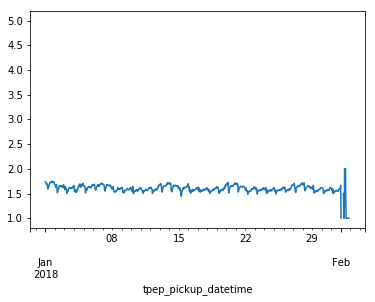

In [73]:
%matplotlib inline
df2 = df2.loc['2018-01':'2018-03'].persist()
df2.passenger_count.resample('1h').mean().compute().plot()

In [79]:
client.close()